In [32]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
from matplotlib import animation
import time
from matplotlib import rcParams
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.family': 'sans-serif',
         'text.usetex': False}
rcParams.update(params)
%matplotlib notebook

class cross_diffusion_2species:
    
    def __init__(self,L,N,dt, init_rho_1, init_rho_2,tmax):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L/N
        self.tmax = tmax
        self.chalf = np.linspace(-L,L,int(2*N+1))
        self.cspan = np.linspace(-L + self.dx/2, L - self.dx/2, int(2*N))
        self.rho = [np.concatenate([init_rho_1,init_rho_2])]

    def disc_entropy(self,f,g):
        return f + g
    
    def velocities(self,h):
        return -(h[1:]-h[:-1])/self.dx
    
    def flux(self,v,g):
        zero_vec = np.zeros(len(v))
        F = g[:-1]*np.maximum(v,zero_vec) + g[1:]*np.minimum(v,zero_vec)
        return np.concatenate([[0],F,[0]])
    
    def dpdt(self,t,p):
        p1, p2 = np.split(p,2)
        h = self.disc_entropy(p1,p2)
        F1 = self.flux(self.velocities(h),p1) 
        F2 = self.flux(self.velocities(h),p2) 
        diff_1 = -1*(F1[1:]-F1[:-1])/self.dx + 0.3*p1*(1-p1-p2)
        diff_2 =  -1*(F2[1:]-F2[:-1])/self.dx + 0.3*p2*(1-p2-p1)
        return np.concatenate([diff_1, diff_2])
    
    def euler(self):
        t = 0
        while t < self.tmax:
            t += self.dt
            self.rho.append(self.dt*self.dpdt(t,self.rho[-1]) + self.rho[-1])
        return np.array(self.rho)
    
    
    def solve(self):
        solODE = ode(self.dpdt).set_integrator('dopri5')
        solODE.set_initial_value(self.rho[-1],0)
        t = 0
        while t < self.tmax:
            print('t = %.2f'% t,end = '\r')
            t += self.dt
            self.rho.append(solODE.integrate(t))
        return np.array(self.rho)
        

In [33]:
N = 120
L = 4
dt = .08
tmax = 60
dx = L/N
print(dx)
xspan = np.linspace(-L + dx/2, L - dx/2, int(2*N))


init_rho_1 = np.array([0.3 if abs(i + 2.5) < 2 else 0 for i in xspan])
init_rho_2 = np.array([0.3 if abs(i - 2.5) < 1 else 0 for i in xspan])
#init_rho = np.array([np.exp(-i**2*100) for i in xspan])
#xc = .2
#init_rho = 0.1/np.sqrt(2*np.pi*0.2)*np.exp(-(xspan-xc)**2/2/0.2)
#init_rho = np.exp(-xspan**2/2)/np.sqrt(2*np.pi)
#init_rho_1 = 1/np.sqrt(8*np.pi)*np.exp(-.5*(xspan+3)**2)
#init_rho_2 = 1/np.sqrt(8*np.pi)*np.exp(-.5*(xspan-3)**2)

solver = cross_diffusion_2species(L,N,dt,init_rho_1,init_rho_2,tmax)
dp = solver.dpdt(0,solver.rho[-1])
rho_sol = solver.solve()

0.03333333333333333


<IPython.core.display.Javascript object>


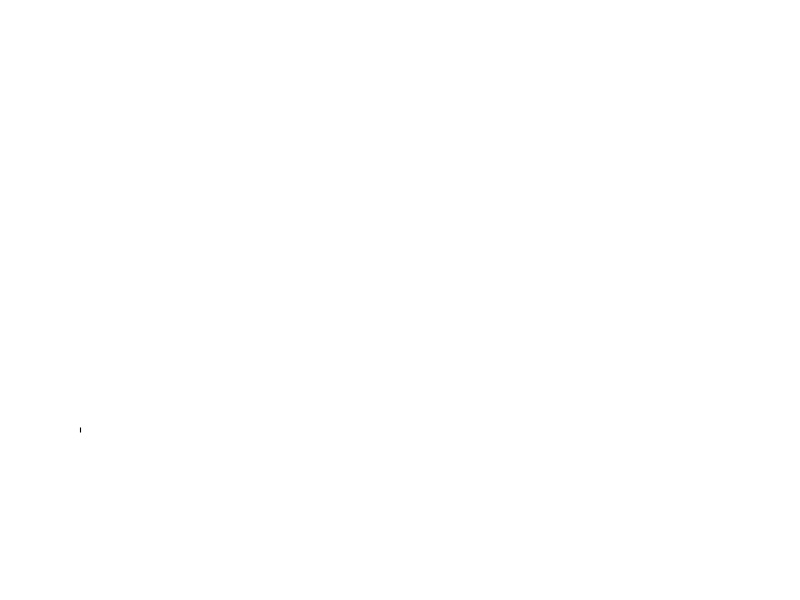

KeyboardInterrupt: 

In [31]:
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%1 == 0]
rho_1 = [np.split(r,2)[0] for r in rho]
rho_2 = [np.split(r,2)[1] for r in rho]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-L,L)
ax.set_ylabel('$\\rho$')
ax.set_xlabel('$x$')
ax.set_ylim(0,1.01*np.max(rho))
plt.ion()
fig.show()
fig.canvas.draw()
tspan = np.linspace(0,tmax,len(rho))
for i in range(len(rho)):
    ax.plot(solver.cspan,rho_1[i],color = 'r',linewidth = 1)
    ax.plot(solver.cspan,rho_2[i],color = 'g',linewidth = 1)
    #ax.plot(solver.cspan,rho_1[i] + rho_2[i],color='black',linewidth = 1)
    ax.set_title('$t = %.2f$' % tspan[i])
    fig.canvas.draw()
    del ax.lines[:]
#ax.plot(solver.cspan,1/np.pi*np.sqrt(2-solver.cspan**2),color = 'dodgerblue')
ax.plot(solver.cspan,rho[-1],'black',linewidth = 1)
plt.show()
len(rho)

In [15]:
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%2== 0]
rho_1 = [np.split(r,2)[0] for r in rho]
rho_2 = [np.split(r,2)[1] for r in rho]
tspan = np.linspace(0,tmax,len(rho))
fig = plt.figure()
ax = plt.axes(xlim=(-L,L), ylim=(0,1.05*np.max(rho)))
line1, = ax.plot([], [], lw=1,color = 'red')
line2, = ax.plot([], [], lw=1,color = 'green')
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    ax.set_ylabel('$\\rho,\\eta$')
    ax.set_xlabel('$x$')
    ax.set_ylim(0,1.02*np.max(rho))
    return [line1,line2]

def animate(i,line1,line2):
    x = solver.cspan
    y1 = rho_1[i]
    y2 = rho_2[i]
    ax.set_title('$t = %.2f$' % tspan[i])
    line1.set_data(x, y1)
    line2.set_data(x, y2)
    return [line1,line2]
anim = animation.FuncAnimation(fig, animate, init_func=init,fargs = [line1,line2],
                               frames= len(rho) - 2)
anim.save('2species_1d_nld.mp4', fps=30,dpi = 300)

In [19]:
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%2== 0]
rho_1 = [np.split(r,2)[0] for r in rho]
rho_2 = [np.split(r,2)[1] for r in rho]
tspan = np.linspace(0,tmax,len(rho))
fig = plt.figure()
ax = plt.axes(xlim=(-L,L), ylim=(0,1.05*np.max(rho)))
line, = ax.plot([], [], lw=1,color = 'black')
def init():
    line.set_data([], [])
    ax.set_ylabel('$\\rho$')
    ax.set_xlabel('$x$')
    ax.set_ylim(0,1.02*np.max(rho))
    return line,

def animate(i):
    x = solver.cspan
    y = rho_1[i]+rho_2[i]
    ax.set_title('$t = %.2f$' % tspan[i])
    line.set_data(x, y)
    return line,
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames= len(rho) - 2)
anim.save('2species_1d_nld_sum.mp4', fps=30,dpi = 300)

<IPython.core.display.Javascript object>


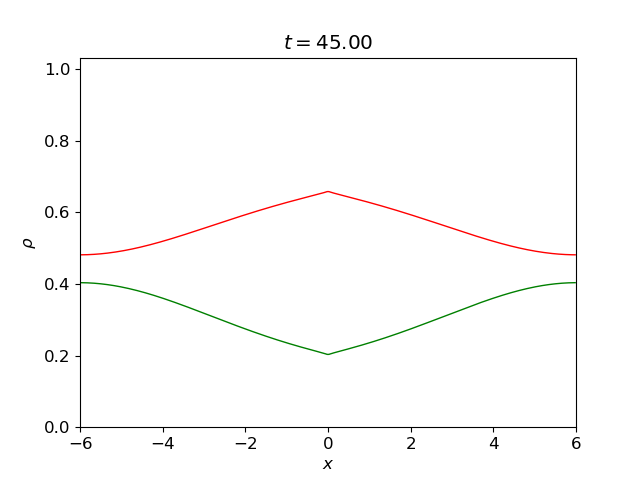

ValueError: x and y must have same first dimension, but have shapes (300,) and (600,)

In [64]:
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%1 == 0]
rho_1 = [np.split(r,2)[0] for r in rho]
rho_2 = [np.split(r,2)[1] for r in rho]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-L,L)
ax.set_ylabel('$\\rho$')
ax.set_xlabel('$x$')
ax.set_ylim(0,1.01*np.max(rho))
plt.ion()
fig.show()
fig.canvas.draw()
tspan = np.linspace(0,tmax,len(rho))
for i in range(len(rho)):
    ax.plot(solver.cspan,rho_1[i],color = 'r',linewidth = 1)
    ax.plot(solver.cspan,rho_2[i],color = 'g',linewidth = 1)
    #ax.plot(solver.cspan,rho_1[i] + rho_2[i],color='black',linewidth = 1)
    ax.set_title('$t = %.2f$' % tspan[i])
    fig.canvas.draw()
    del ax.lines[:]
#ax.plot(solver.cspan,1/np.pi*np.sqrt(2-solver.cspan**2),color = 'dodgerblue')
ax.plot(solver.cspan,rho[-1],'black',linewidth = 1)
plt.show()
len(rho)

In [54]:
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%1== 0]
rho_1 = [np.split(r,2)[0] for r in rho]
rho_2 = [np.split(r,2)[1] for r in rho]
tspan = np.linspace(0,tmax,len(rho))
fig = plt.figure()
ax = plt.axes(xlim=(-L,L), ylim=(0,1.15*np.max(rho)))
line, = ax.plot([], [], lw=1,color = 'black')
def init():
    line.set_data([], [])
    ax.set_ylabel('$\\rho$')
    ax.set_xlabel('$x$')
    ax.set_ylim(0,1.2*np.max(rho))
    ax.text(-L*0.95,np.max(rho),'$W(x) = 0$', color = 'b')
    ax.text(-L*0.95,1.07*np.max(rho),"$H'(\\rho) =\\rho$ ",color = 'b')
    ax.text(-L*0.95,1.14*np.max(rho),"$V(x) = x^4/4 - x^2/2$ ",color = 'b')
    return line,
def animate(i):
    x = solver.cspan
    y = rho[i]
    ax.set_title('$t = %.2f$' % tspan[i])
    line.set_data(x, y)
    return line,
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames= len(rho) - 2)
anim.save('doublewell_asymmetric.mp4', fps=30,dpi = 300)

<IPython.core.display.Javascript object>

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [9]:
l = np.array([1,2,3,4])
a,b = np.split(l,2)

In [10]:
a

array([1, 2])

In [11]:
b

array([3, 4])